# Background

[Nightwish](https://nightwish.com/) is a symphonic power metal band from Finland and one of the biggest names in the European metal scene. Since 1996, they have released 9 studio albums and numerous singles, EP's, and live albums. The most recent album *Human. :II: Nature.* just came out in April 2020. Throughout their career, Nightwish has explored a wide variety of themes, ranging from love and sorrow to science and nature. As a Nightwish fan and aspiring data scientist, I thought it might be super interesting to look at how the lyrical themes of Nightwish have evolved over the past 24 years.

Inpsired by this [Taylor Swift dataset](https://www.kaggle.com/PromptCloudHQ/taylor-swift-song-lyrics-from-all-the-albums) on Kaggle ([example analysis](https://news.codecademy.com/taylor-swift-lyrics-machine-learning/)), I scraped all of Nightwish's lyrics from the metal lyrics archive [Dark Lyrics](http://www.darklyrics.com/) using [this script](https://github.com/medakk/darklyrics-scraper) and shared [my dataset](https://www.kaggle.com/crazyrichbayesians/nightwish-lyrics) on Kaggle under the [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/) license. Eventually, I want to use methods such as topic modeling to find out the most common topics in Nightwish songs and examine how they have changed over time. Even cooler, maybe we can train a neural net to write new lyrics in the style of Nightwish!

Before all that fancy modeling, let's do some exploratory data analysis (EDA) first. For instance, how do songs cluster together by lyrics? How can we represent Nightwish lyrics in a low-dimensional space?... This notebook is dedicated to EDA of the Nightwish lyrics dataset.

# Data preparation

In [1]:
# Import libraries
import re
import pandas as pd

pd.options.mode.chained_assignment = None
import numpy as np
import clean
import spacy
import en_core_web_lg
from gensim.models import word2vec
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib.patches import Ellipse
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn import metrics
import word_2dviz

import warnings

warnings.filterwarnings("ignore")

%load_ext lab_black

unable to import 'smart_open.gcs', disabling that module


## Load data

In [2]:
# Read from text file
with open("nightwish_lyrics.txt") as f:
    raw = f.read().splitlines()

In [3]:
# Get rid of unwanted strings
raw = [
    re.sub(r"\*{2,}", "", str(i)) for i in raw
]  # Dividers '****************************'

raw = [i for i in raw if i]  # Empty strings

raw = [i for i in raw if "[" not in i]  # Strings containing "["

In [4]:
# Convert to dataframe
df = pd.DataFrame(raw, columns=["lyric"])

## Text mining

In [5]:
# Function for extracting titles
def title_extract(idx_start):

    # Where album/song ends
    idx_end = idx_start[1:]

    idx_end.append(len(df))

    # Number of lines in album/song
    lines = [i - j for i, j in zip(idx_end, idx_start)]

    # Album/song titles
    titles = df["lyric"].iloc[idx_start].values.tolist()

    # Repeat titles by the number of lines
    titles_nested = [[i] * j for i, j in zip(titles, lines)]

    # Return as a list
    return [item for items in titles_nested for item in items]

In [6]:
# Find beginning of ablum titles
album_start = df.index[df["lyric"].str.contains("*", regex=False)].tolist()

# Add album titles
df["album"] = title_extract(album_start)

# Remove album rows
df = df.drop(album_start).reset_index(drop=True)

# Find beginning song titles
song_start = df.index[df["lyric"].str.contains(r"^[0-9]{1,2}\.\s", regex=True)].tolist()

# Add song titles
df["track"] = title_extract(song_start)

# Remove song rows
df = df.drop(song_start).reset_index(drop=True)

In [7]:
# Extract album titles
df["album_title"] = df["album"].apply(
    lambda x: (
        re.findall(r'"([^"]*)"', x)[0] if re.findall(r'"([^"]*)"', x) else "Non-Album"
    )
)

# Extract years
df["year"] = df["album"].apply(
    lambda x: (
        re.findall(r"\(([^)]+)", x)[0]
        if re.findall(r'"([^"]*)"', x)
        else "Unknown Year"
    )
)

# Extract track titles and numbers
df["track_title"] = df["track"].apply(lambda x: str(x).split(". ")[1])

df["track_number"] = df["track"].apply(lambda x: str(x).split(". ")[0])

# Drop original ablum and track columns
df.drop(["album", "track"], axis=1, inplace=True)

## Word2Vec

### Text cleaning
I created a custom module `clean`for text cleaning, which includes functions for normalization, stop word removal, and lemmatization.

#### Normalization

First of all, we want the same words to be treated as the same. This means we need to deal with cases (e.g., "Have" vs. "have"), contradictions (e.g., "it's" vs. "it is"), misspellings (e.g., "believ" vs. "believe"), etc. It's also a [standard practice](https://www.kaggle.com/saga21/disaster-tweets-comp-introduction-to-nlp/notebook) in Natural Language Processing (NLP) to replace accented characters ( e.g., "Élan") with "plain" characters (e.g., "Elan") and to remove punctuations, white spaces, etc. that don't bear any meanings. This whole process is often called "normalization".

The `clean` module has 6 normalization functions: `lower_case()`, `expand_contractions()`, `remove_punct()`, `remove_accented_chars()`,  `correct_spellings()`, and `remove_space()`. The catch-all `normalization()` function executes them in exactly this order.

In [8]:
# Normalization
df["lyric_normalized"] = df["lyric"].apply(lambda x: clean.normalization(x))

In [9]:
# Remove new punctuations created by SpellChecker()
df["lyric_normalized"] = df["lyric_normalized"].apply(lambda x: clean.remove_punct(x))

# Remove new spaces
df["lyric_normalized"] = df["lyric_normalized"].apply(lambda x: clean.remove_space(x))

#### Stop word removal
[Stop words](https://kavita-ganesan.com/what-are-stop-words/#.Xp9ZE9NKjpA) are common words that don't often contribute new information, such as pronouns (e.g., I, its, yourself, etc.), determiners (e.g., a, the), conjunctions (e.g., for, an, nor, but, or, yet, so), and prepositions (e.g., in, under, towards, before). We can use the spaCy library to remove stop words.

In [10]:
# Load pre-trained English model
nlp = en_core_web_lg.load()

In [11]:
# Remove stop words
df["lyric_nostop"] = df["lyric_normalized"].apply(
    lambda x: clean.remove_stopwords(nlp(x))
)

#### Lemmatization
Words like "wanted", "wants", and "want" share the same root but have different inflectional forms. Instead of representing each form separately, we can use "lemmatization" to return each word to its [lemma](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html) (i.e., its base or dictionary form). The spaCy libarary also makes lemmatization really convenient.

In [12]:
# Lemmatize words
df["lyric_lemma"] = df["lyric_nostop"].apply(lambda x: clean.lemmatizer(nlp(x)))

#### Save results
We can save the cleaned dataset so in the future we don't have to go through the entire process from scratch.

In [13]:
# Save as CSV
df.to_csv("nightwish_lyrics.csv", index=False, header=True)

In [14]:
# Drop rows that no longer have lyrics
df_clean = df.dropna()

### Word embeddings

#### For each line of lyrics

In [15]:
# Average vectors for each line of lyrics
X_lyric = np.array(
    [nlp(lyric["lyric_lemma"]).vector for idx, lyric in df_clean.iterrows()]
)

# Center the vectors
vec_mean = X_lyric.mean(axis=0)

X_lyrics = pd.DataFrame([vec - vec_mean for vec in X_lyric])

#### For each word in vocabulary

In [16]:
# Create a corpus
corpus = df_clean["lyric_lemma"].tolist()

corpus = [i for i in corpus if i]

# Tokenize sentences
tokenized_sentences = [sentence.split() for sentence in corpus]

# Train model (words should appear at least 10 times)
model = word2vec.Word2Vec(tokenized_sentences, min_count=10)

# Save model
model.save("model.bin")

# Retrieve vectors
X_vocab = model[model.wv.vocab]

# Cluster analysis

## DBSCAN

### Hyper-parameter tuning

In [17]:
# def dbscan(X, eps, min_samples):
#     ss = StandardScaler()
#     X = ss.fit_transform(X)
#     db = DBSCAN(eps=eps, min_samples=min_samples)
#     db.fit(X)
#     y_pred = db.fit_predict(X)
#     plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap="Paired")
#     plt.title("DBSCAN")

# Dimension reduction

## PCA

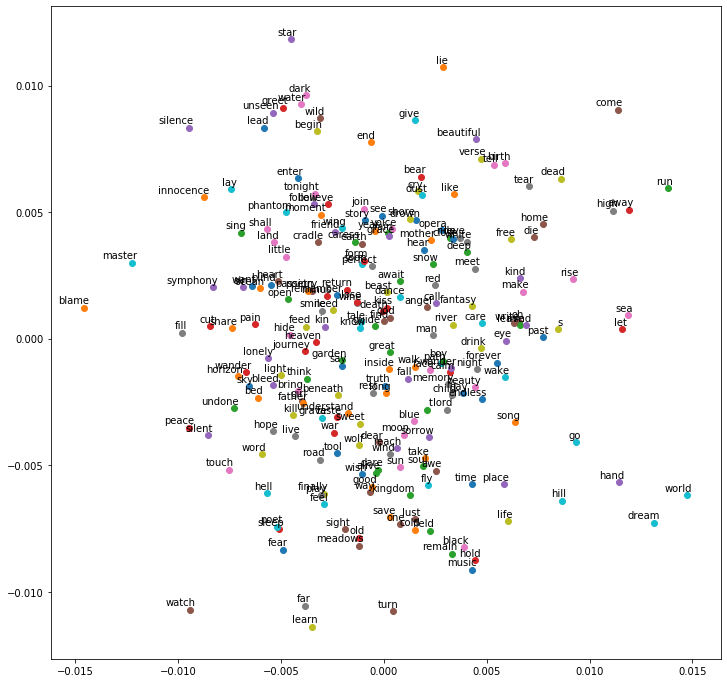

In [18]:
word_2dviz.pca_plot(model)

## t-SNE

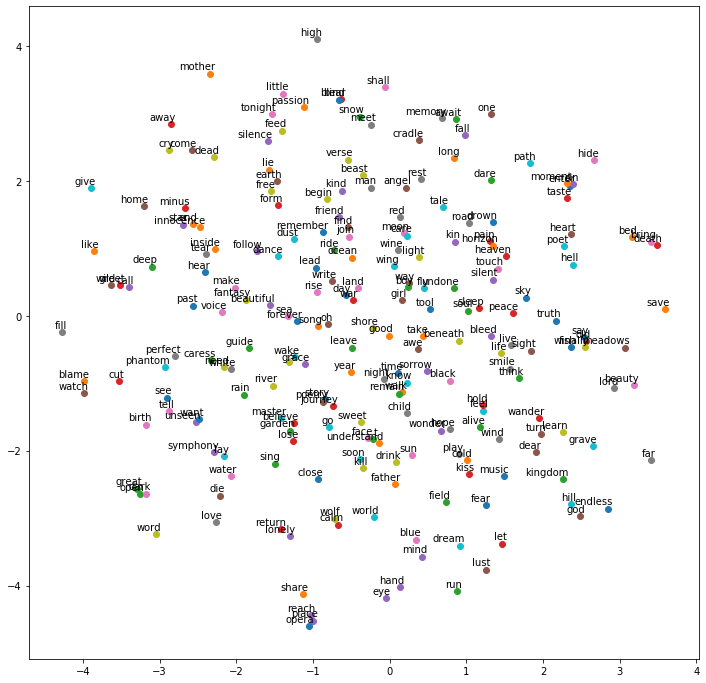

In [19]:
word_2dviz.tsne_plot(model)

## UMAP

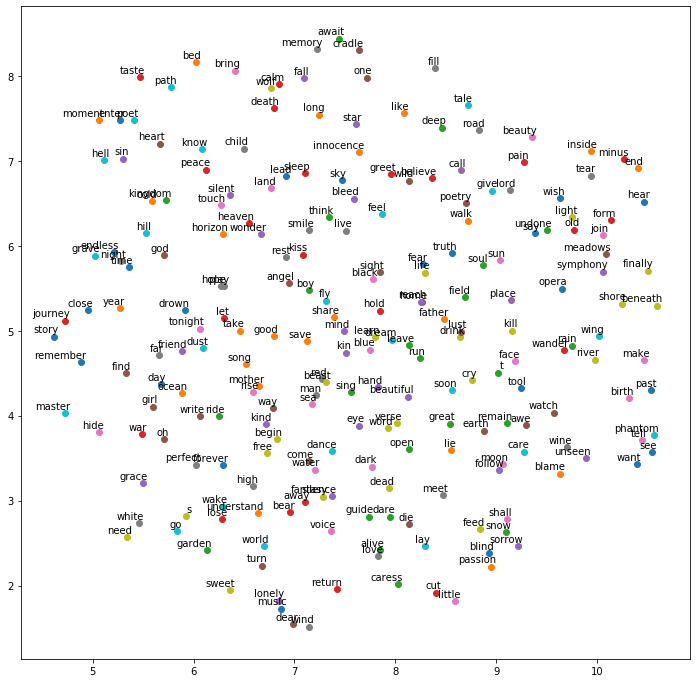

In [20]:
word_2dviz.umap_plot(model)